# Project invoices
*KUBIK Aleksander - KOBANA Johan - JOUYIT Matthieu - Thomas BOULAINE - DIA4*


Our problem : How can we analyze and visualize an online store’s activity using an invoice dataset to extract key indicators that support data-driven decisions?



In [3]:
import pandas as pd 
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

from sklearn.preprocessing import OneHotEncoder
from category_encoders import TargetEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

import plotly_express as px
import plotly.graph_objects as go

from mlxtend.frequent_patterns import fpgrowth, association_rules

from prophet import Prophet


In [4]:
def load_data(file_path):
    df = pd.read_csv(file_path)

    return df
invoice = load_data('invoices.csv')

In [5]:
#Basic info
def basic_info(data):
    print("Shape:", data.shape)
    print("\nColumns:", data.columns.tolist())

    print("\nData types:")
    print(data.dtypes)

    print("\nMissing values per column:")
    print(data.isna().sum())

Shape: (10000, 11)

Columns: ['first_name', 'last_name', 'email', 'product_id', 'qty', 'amount', 'invoice_date', 'address', 'city', 'stock_code', 'job']

Data types:
first_name       object
last_name        object
email            object
product_id        int64
qty               int64
amount          float64
invoice_date     object
address          object
city             object
stock_code        int64
job              object
dtype: object

Missing values per column:
first_name      0
last_name       0
email           0
product_id      0
qty             0
amount          0
invoice_date    0
address         0
city            0
stock_code      0
job             0
dtype: int64


In [6]:
def preprocess_dates(data):
    """
    Convert invoice_date to datetime and extract year/month.
    """
    data["invoice_date"] = pd.to_datetime(data["invoice_date"], format="%d/%m/%Y")
    data["year"] = data["invoice_date"].dt.year
    data["month"] = data["invoice_date"].dt.month
    data["product_id"] = data["product_id"].astype(str)
    return data

,first_name,last_name,email,product_id,qty,amount,invoice_date,address,city,stock_code,job,year,month
0,Carmen Nixon,Todd Anderson,marvinjackson@example.com,133,9,14.57,1982-09-10,283 Wendy Common,West Alexander,36239634,Logistics and distribution manager,1982,9
1,Mrs. Heather Miller,Julia Moore,jeffrey84@example.net,155,5,65.48,2012-10-03,13567 Patricia Circles Apt. 751,Andreamouth,2820163,Osteopath,2012,10
2,Crystal May,Philip Moody,ugoodman@example.com,151,9,24.66,1976-03-23,6389 Debbie Island Suite 470,Coxbury,27006726,Economist,1976,3
3,Bobby Weber,Mark Scott,ssanchez@example.com,143,4,21.34,1986-08-17,6362 Ashley Plaza Apt. 994,Ninaland,83036521,Sports administrator,1986,8
4,Kristen Welch,David David,cynthia66@example.net,168,2,83.90,1996-06-11,463 Steven Cliffs Suite 757,Isaiahview,80142652,Chief Marketing Officer,1996,6


Here we convert the `invoice_date` column into a real datetime format.  
We also create two new columns: `year` and `month`.

These will be useful later when we study trends in sales over time.

In [8]:
def sales_by_month(invoice):
    """
    Compute total monthly revenue based on 'amount'.
    """
    monthly_sales = invoice.groupby(["year", "month"])["amount"].sum().reset_index()
    monthly_sales["date"] = pd.to_datetime(
        monthly_sales["year"].astype(str) + "-" + monthly_sales["month"].astype(str) + "-01"
    )#vrm intéressant vu qu'on a déjà year et month ?
    return monthly_sales

,year,month,amount,date
0,1970,1,776.42,1970-01-01
1,1970,2,1089.66,1970-02-01
2,1970,3,1147.24,1970-03-01
3,1970,4,522.42,1970-04-01
4,1970,5,411.65,1970-05-01


This function calculates the total sales for each month.  
We group the data by year and month, then sum the amounts.

It gives us our first time-based indicator: how the store’s sales evolve over time.

In [231]:
def top_products(df, n=10):
    """
    Identify the top N best-selling products (sum of quantities).
    """
    top = (
        df.groupby("product_id")["amount"]
        .sum()
        .reset_index()
        .sort_values(by="amount", ascending=False)
        .head(n)
    )
    return top

In [12]:
def average_basket(invoice):
    """
    Compute the average spending per customer.
    """
    avg = invoice.groupby("email")["amount"].mean().reset_index()
    avg.rename(columns={"amount": "avg_basket"}, inplace=True)
    return avg

,email,avg_basket
0,aadams@example.net,62.08
1,aallen@example.net,89.56
2,aallen@example.org,53.86
3,aalvarez@example.net,88.36
4,aaron23@example.com,32.12


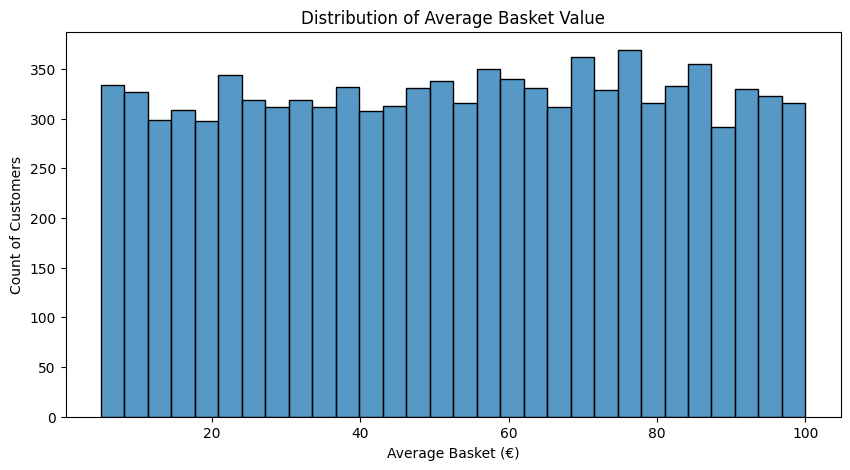

In [13]:
plt.figure(figsize=(10,5))
sns.histplot(avg_basket["avg_basket"], bins=30)
plt.title("Distribution of Average Basket Value")
plt.xlabel("Average Basket (€)")
plt.ylabel("Count of Customers")
plt.show()


In [159]:
def pattern_mining_by_job(df, min_support=0.01, top_n=10):

    basket = df.groupby(['job', 'product_id'])['qty'].sum().unstack().fillna(0)
    basket = basket > 0

    itemsets = fpgrowth(basket, min_support=min_support, use_colnames=True)
    if itemsets.empty:
        return pd.DataFrame({"message": ["No frequent itemsets found"]})

    rules = association_rules(itemsets, metric="lift", min_threshold=0)
    if rules.empty:
        return pd.DataFrame({"message": ["No association rules found"]})

    rules["score"] = rules["lift"] * rules["confidence"]
    rules = rules.sort_values(by="score", ascending=False).head(top_n)

    # Convert sets to text
    rules["antecedent_txt"] = rules["antecedents"].apply(lambda x: list(x)[0])
    rules["consequent_txt"] = rules["consequents"].apply(lambda x: list(x)[0])

    # Add list of jobs that support each rule
    def get_jobs_supporting_rule(row):
        a = row["antecedent_txt"]
        b = row["consequent_txt"]

        jobs_A = set(df[df["product_id"] == a]["job"])
        jobs_B = set(df[df["product_id"] == b]["job"])

        return sorted(jobs_A.intersection(jobs_B))

    rules["jobs_supporting_rule"] = rules.apply(get_jobs_supporting_rule, axis=1)

    return rules[[
        "antecedent_txt",
        "consequent_txt",
        "confidence",
        "lift",
        "score",
        "jobs_supporting_rule"
    ]]

In [175]:
def geo_clustering(invoice, k=4):
    """
    Apply KMeans clustering on cities using frequency of purchases.
    """
    city_counts = invoice["city"].value_counts().reset_index()
    city_counts.columns = ["city", "orders"]

    scaler = StandardScaler()
    city_counts["scaled"] = scaler.fit_transform(city_counts[["orders"]])

    kmeans = KMeans(n_clusters=k, random_state=0)
    city_counts["cluster"] = kmeans.fit_predict(city_counts[["scaled"]])

    return city_counts

,city,orders,scaled,cluster
0,Lake James,12,14.126202,3
1,South James,10,11.489116,3
2,South Jennifer,9,10.170574,3
3,Lake Michael,9,10.170574,3
4,South David,9,10.170574,3


In [207]:
def temporal_analysis(df, last_n_years=5, window_months=6, forecast_months=0):
    """
    Temporal analysis using data only (no Matplotlib figure).
    Returns:
        monthly_df : DataFrame with date and monthly amount
        trend_df   : DataFrame with rolling trend
        forecast   : Prophet forecast dataframe (or None)
    """

    df = df.copy()
    df["invoice_date"] = pd.to_datetime(df["invoice_date"])

    # Filter last N years
    max_year = df["invoice_date"].dt.year.max()
    min_year = max_year - last_n_years + 1
    df = df[df["invoice_date"].dt.year >= min_year]

    # Monthly aggregation
    monthly = (
        df.groupby(df["invoice_date"].dt.to_period("M"))["amount"]
        .sum()
        .to_timestamp()
        .reset_index(name="amount")
        .rename(columns={"invoice_date": "date"})
    )

    # Trend
    monthly["trend"] = monthly["amount"].rolling(window=window_months).mean()

    # Forecast with Prophet
    if forecast_months > 0:
        prophet_df = monthly.rename(columns={"date": "ds", "amount": "y"})
        model = Prophet(yearly_seasonality=True)
        model.fit(prophet_df[["ds", "y"]])
        future = model.make_future_dataframe(periods=forecast_months, freq="ME")
        forecast = model.predict(future)
    else:
        forecast = None

    return monthly, forecast

In [209]:
temp = temporal_analysis(invoice, last_n_years=10, window_months=6, forecast_months=12)
temp

17:03:23 - cmdstanpy - INFO - Chain [1] start processing
17:03:23 - cmdstanpy - INFO - Chain [1] done processing


(          date   amount       trend
 0   2013-01-01   598.02         NaN
 1   2013-02-01   811.09         NaN
 2   2013-03-01   666.62         NaN
 3   2013-04-01  1030.35         NaN
 4   2013-05-01   954.78         NaN
 ..         ...      ...         ...
 104 2021-09-01   975.30  752.580000
 105 2021-10-01   797.76  784.988333
 106 2021-11-01   768.78  760.775000
 107 2021-12-01   733.11  809.405000
 108 2022-01-01   503.50  751.676667
 
 [109 rows x 3 columns],
             ds       trend  yhat_lower   yhat_upper  trend_lower  trend_upper  \
 0   2013-01-01  818.528039  477.423525  1042.494902   818.528039   818.528039   
 1   2013-02-01  817.809174  542.372934  1101.582366   817.809174   817.809174   
 2   2013-03-01  817.159876  617.946225  1175.313065   817.159876   817.159876   
 3   2013-04-01  816.441011  408.732935   977.107195   816.441011   816.441011   
 4   2013-05-01  815.745336  471.873855  1015.450297   815.745336   815.745336   
 ..         ...         ...         .

In [217]:
# Main pipeline
def main():

    # --------------------------
    # 1. Load and preprocess data
    # --------------------------
    invoice = load_data("invoices.csv")
    invoice = preprocess_dates(invoice)

    # --------------------------
    # 2. Compute core indicators
    # --------------------------
    monthly_sales = sales_by_month(invoice)
    top10 = top_products(invoice)
    avg_basket = average_basket(invoice)

    # --------------------------
    # 3. Pattern mining (job-based rules)
    # --------------------------
    rules = pattern_mining_by_job(invoice, min_support=0.02, top_n=10)

    # --------------------------
    # 4. Temporal analysis + Prophet forecasting
    # --------------------------
    monthly, forecast = temporal_analysis(
    invoice,
    last_n_years=10,
    window_months=6,
    forecast_months=12
    )

    # --------------------------
    # 5. City clustering (commercial activity)
    # --------------------------
    city_clustering = geo_clustering(invoice, k=4)

    print("Pipeline executed successfully.")

    # Return all outputs
    return {
        "invoice": invoice,
        "monthly_sales": monthly_sales,
        "top10": top10,
        "avg_basket": avg_basket,
        "rules": rules,
        "monthly": monthly,
        "forecast": forecast,
        "city_clustering" : geo_clustering
    }

In [219]:
#Main execution
if __name__ == "__main__":
    results = main()

17:07:01 - cmdstanpy - INFO - Chain [1] start processing
17:07:01 - cmdstanpy - INFO - Chain [1] done processing


Pipeline executed successfully.


In [235]:
from dash import Dash, dcc, html, dash_table
import dash_bootstrap_components as dbc
import plotly.express as px

# --------- Run your pipeline ---------
data = main()

top10 = data["top10"]
rules = data["rules"]
monthly = data["monthly"]
forecast = data["forecast"]
#city_clusters = data["city_clusters"]

# ============================================
# 1. FIGURE Top 10 Products
# ============================================
fig_top10 = px.bar(
    top10,
    x="product_id",
    y="amount",
    title="Top 10 Products"
)

# ============================================
# 2. FIGURE Pattern Mining Rules
# ============================================
fig_rules = px.scatter(
    rules,
    x="confidence",
    y="lift",
    size="score",
    color="consequent_txt",
    hover_name="antecedent_txt",
    title="Association Rules (Products Bought Together)"
)

# ============================================
# 3. FIGURE Temporal Analysis (monthly + trend + forecast)
# ============================================

fig_temp = px.line(
    monthly,
    x="date",
    y="amount",
    title="Monthly Sales (Last 10 Years)"
)

# Add trend line
fig_temp.add_scatter(
    x=monthly["date"],
    y=monthly["trend"],
    mode="lines",
    name="Trend (Rolling Mean)",
    line=dict(color="orange", width=3)
)

# Add forecast
if forecast is not None:
    fig_temp.add_scatter(
        x=forecast["ds"],
        y=forecast["yhat"],
        mode="lines",
        name="Forecast",
        line=dict(color="green", width=2)
    )

# ============================================
# 4. FIGURE City Clustering
# ============================================

#fig_clusters = px.scatter(
#    city_clusters,
#    x="orders",
#    y="scaled",
#    color="cluster",
#    hover_name="city",
#    title="City Clustering (Purchase Activity)"
#)

# ============================================
# DASH APP LAYOUT
# ============================================

app = Dash(__name__, external_stylesheets=[dbc.themes.BOOTSTRAP])

app.layout = html.Div([
    
    html.H1("Invoices Dashboard", style={"textAlign": "center"}),

    html.H2("Top 10 Products"),
    dcc.Graph(figure=fig_top10),

    html.H2("Pattern Mining (Job-Based Rules)"),
    dcc.Graph(figure=fig_rules),

    html.H2("Temporal Analysis (Monthly + Trend + Forecast)"),
    dcc.Graph(figure=fig_temp),

    #html.H2("City Clustering (Commercial Activity)"),
    #dcc.Graph(figure=fig_clusters)
])

if __name__ == "__main__":
    app.run(debug=True)

17:15:03 - cmdstanpy - INFO - Chain [1] start processing
17:15:03 - cmdstanpy - INFO - Chain [1] done processing


Pipeline executed successfully.
